<a href="https://colab.research.google.com/github/davidguzmanr/CSC2516/blob/main/cifar10/Membership-inference-CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
! git clone https://github.com/davidguzmanr/CSC2516.git

Cloning into 'CSC2516'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 186 (delta 111), reused 103 (delta 47), pack-reused 0
Receiving objects: 100% (186/186), 3.11 MiB | 4.58 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [23]:
%cd CSC2516/ 

/content/CSC2516/CSC2516


In [24]:
! pip install -r requirements.txt --quiet

In [25]:
import urllib.request
import zipfile
import os
from collections import OrderedDict
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import random
from numpy.random import choice
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torchvision import models
from torchvision.datasets import CIFAR10
from torchvision import transforms

from opacus.validators import ModuleValidator

from art.utils import load_mnist, load_cifar10
from art.estimators.classification.pytorch import PyTorchClassifier
from art.attacks.inference.membership_inference import MembershipInferenceBlackBoxRuleBased

SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


# Models

In [26]:
url = "https://csc2516-neural-networks-and-deep-learning.s3.amazonaws.com/cifar10/lightning_logs.zip"
filename = "lightning_logs.zip"

urllib.request.urlretrieve(url, filename)

with zipfile.ZipFile('lightning_logs.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [27]:
def match_keys(state_dict: OrderedDict) -> OrderedDict:
    """
    Match the keys in a PyTorch Lightning state dictionary with a PyTorch format.
    
    Parameters:
    -----------
    state_dict : OrderedDict
        The state dictionary to be matched.
        
    Returns:
    --------
    OrderedDict
        A new state dictionary with the keys in a PyTorch format.
    """
    new_dict = OrderedDict()
    
    # For whatever reason PyTorch Lightning adds the word 'model.' at the beginning
    # of each key, so we have a mismatch in the keys. The problem goes away if we 
    # use our custom LightningModule to load the model, but I don't want to do that.
    for key in state_dict:
        # It saves the weights twice, in the second one it adds 'private_model.' to the key
        if 'private_model' not in key:
            # Remove the first part of the key, which is 'model.' for PyTorch Lightning
            new_key = '.'.join(key.split('.')[1:])
            new_dict[new_key] = state_dict[key]
        
    return new_dict

In [28]:
def find_pt_files(directory: str):
    """
    Recursively searches for files with the ".pt" extension in a given directory.
    Returns a list of file paths.

    Args:
        directory (str): The path to the directory to search for ".pt" files.

    Returns:
        A list of file paths to all the ".pt" files in the given directory and its subdirectories.
    """
    # Create an empty list to store the file paths of all ".pt" files found
    pt_files = []

    # Walk through the directory tree and search for files with the ".pt" extension
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".ckpt"):
                # If a file with the ".pt" extension is found, append its path to the list
                pt_files.append(os.path.join(root, file))
    
    # Return the list of file paths of all ".pt" files found
    return pt_files


In [29]:
def load_model(path: str, device: str):
    """
    Loads a PyTorch model from a saved checkpoint at the given path.
    The model is loaded onto the specified device.
    Returns the loaded model.

    Args:
        path (str): The path to the saved checkpoint.
        device (str): The device onto which the model should be loaded.
            Must be a string that PyTorch recognizes as a valid device identifier.

    Returns:
        The loaded PyTorch model.
    """
    # Load the checkpoint from the specified path
    checkpoint = torch.load(path, map_location=device)

    # Load a ResNet18 model with 10 output classes, and fix its module naming
    model = ModuleValidator.fix(models.resnet18(num_classes=10))

    # Match the keys of the loaded state dict to the keys of the model's state dict
    state_dict = match_keys(checkpoint['state_dict'])

    # Load the state dict into the model, and move the model onto the specified device
    model.load_state_dict(state_dict)
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Return the loaded model
    return model

In [30]:
checkpoints = find_pt_files('lightning_logs/')
models_with_regularization = sorted([model for model in checkpoints if 'with-regularization' in model])
models_without_regularization = sorted([model for model in checkpoints if 'no-regularization' in model])

## Dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


x.shape torch.Size([3, 32, 32])
x.mean 0.18823836743831635


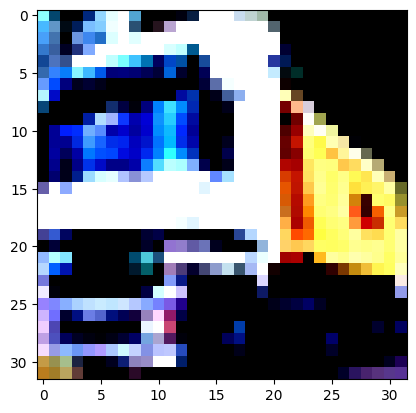

In [31]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)

normalize = [
    transforms.ToTensor(),
    # If necessary, they can be computed with modest privacy budgets.
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
]
transform = transforms.Compose(normalize)

cifar10_train = CIFAR10('data', train=True, transform=transform, download=True)
cifar10_test = CIFAR10('data', train=False, transform=transform, download=True)

x, y = cifar10_train.__getitem__(1)

print(f'x.shape {x.shape}')
print(f'x.mean {x.mean()}')

plt.imshow(x.permute(1, 2, 0))
plt.show()

In [32]:
x_train = np.array([x.numpy() for (x, y) in tqdm(cifar10_train)])
y_train = np.array([y for (x, y) in tqdm(cifar10_train)])

x_test = np.array([x.numpy() for (x, y) in tqdm(cifar10_test)])
y_test = np.array([y for (x, y) in tqdm(cifar10_test)])

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [33]:
type(x_train)

numpy.ndarray

## Attacks

In [34]:
def membership_inference_attack(
    model_path: str, 
    x_train: np.ndarray, 
    y_train: np.ndarray,
    x_test: np.ndarray, 
    y_test: np.ndarray, 
    device: str
    ):
    """
    Performs a membership inference attack on a PyTorch model.
    Returns the accuracy of the model on the test set, and the accuracy of the attack.

    Args:
        model_path (str): The path to the saved PyTorch model checkpoint.
        x_train (np.ndarray): Array with the training data.
        y_train (np.ndarray): Array with the training labels.
        x_test (np.ndarray): Array with the test data.
        y_test (np.ndarray): Array with the test labels.
        device (str): The device onto which the model should be loaded.

    Returns:
        A tuple containing the accuracy of the model on the test set, and the accuracy of the attack.
    """
    # Load the PyTorch model from the specified checkpoint
    model = load_model(model_path, device)

    # Set up the ART PyTorchClassifier for the model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    art_model = PyTorchClassifier(
        model=model, 
        loss=criterion, 
        channels_first=True, 
        input_shape=(3,32,32,), 
        nb_classes=10,
        device_type=device,
        clip_values=(x_train.min(), x_train.max())
    )

    # Make predictions on the test set and calculate the accuracy of the model
    pred = np.array([np.argmax(arr) for arr in art_model.predict(x_test)])
    accuracy = 100 * np.sum(pred == y_test) / len(y_test)

    # Set up the ART MembershipInferenceBlackBoxRuleBased attack
    attack = MembershipInferenceBlackBoxRuleBased(art_model)

    # Perform the attack on the training and test sets
    inferred_train = attack.infer(x_train, y_train)
    inferred_test = attack.infer(x_test, y_test)

    # Calculate the accuracy of the attack
    train_acc = np.sum(inferred_train) / len(inferred_train)
    test_acc = 1 - (np.sum(inferred_test) / len(inferred_test))
    attack_acc = 100 * (train_acc * len(inferred_train) + test_acc * len(inferred_test)) / (len(inferred_train) + len(inferred_test))

    # Uncomment the following lines to print the accuracy results
    # print(f"Members Accuracy: {100 * train_acc:.4f}")
    # print(f"Non Members Accuracy {100 * test_acc:.4f}")
    # print(f"Attack Accuracy {100 * acc:.4f}")

    # Return the accuracy of the model and the accuracy of the attack as a tuple
    return accuracy, attack_acc


### Models with regularization

In [35]:
accuracies = []
attack_accuracies = []

for model in tqdm(models_with_regularization):
    accuracy, attack_accuracy = membership_inference_attack(
        model, x_train, y_train, x_test, y_test, device
    )

    accuracies.append(accuracy)
    attack_accuracies.append(attack_accuracy)


results_with_regularization = pd.DataFrame(
    data={
        'model': models_with_regularization,
        'test_accuracy': accuracies,
        'attack_accuracy': attack_accuracies,
    }
)

results_with_regularization['model'] = results_with_regularization['model'].apply(
    lambda name: name.split('/')[2]
)
# results_with_regularization['regularization'] = True
results_with_regularization.sort_values(by='attack_accuracy', ascending=False)

  0%|          | 0/8 [00:00<?, ?it/s]

,model,test_accuracy,attack_accuracy
6,resnet,77.01,87.075000
7,resnet_data_augmentation,83.65,78.398333
4,epsilon_50,53.17,52.653333
2,epsilon_30,51.72,51.540000
0,epsilon_10,49.18,49.730000
5,epsilon_50_data_augmentation,44.67,46.485000
3,epsilon_30_data_augmentation,42.54,45.103333
1,epsilon_10_data_augmentation,38.73,42.231667


### Models without regularization

In [36]:
accuracies = []
attack_accuracies = []

for model in tqdm(models_without_regularization):
    accuracy, attack_accuracy = membership_inference_attack(
        model, x_train, y_train, x_test, y_test, device
    )

    accuracies.append(accuracy)
    attack_accuracies.append(attack_accuracy)

results_without_regularization = pd.DataFrame(
    data={
        'model': models_without_regularization,
        'test_accuracy': accuracies,
        'attack_accuracy': attack_accuracies,
    }
)

results_without_regularization['model'] = results_without_regularization['model'].apply(lambda name: name.split('/')[2])
# results_without_regularization['regularization'] = False
results_without_regularization.sort_values(by='attack_accuracy', ascending=False)

  0%|          | 0/8 [00:00<?, ?it/s]

,model,test_accuracy,attack_accuracy
6,resnet,72.90,87.850000
7,resnet_data_augmentation,79.44,74.673333
4,epsilon_50,57.14,57.666667
2,epsilon_30,56.03,56.716667
0,epsilon_10,54.12,54.751667
5,epsilon_50_data_augmentation,50.26,50.530000
3,epsilon_30_data_augmentation,49.85,49.805000
1,epsilon_10_data_augmentation,47.72,48.686667


In [37]:
# results = pd.concat([results_with_regularization, results_without_regularization], ignore_index=True)
# results.sort_values(by='attack_accuracy', ascending=False)